In [1]:
# 必要なライブラリのインポート
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

try:
    if os.name == 'posix':  # Mac/Linux
        japanese_fonts = ['Hiragino Sans', 'Hiragino Kaku Gothic Pro', 'Yu Gothic', 'Meiryo']
        for font in japanese_fonts:
            try:
                plt.rcParams['font.family'] = font
                break
            except:
                continue
except:
    pass

plt.rcParams['figure.figsize'] = (12, 8)
print("ライブラリのインポートが完了しました")

ライブラリのインポートが完了しました


In [2]:
def parse_directory_name(dir_name):
    params = dir_name.split(',')
    if len(params) < 30: return None, None, None
    try:
        cpnum = next((int(params[i]) for i in range(10) if int(params[i]) != 0), None)
        cpnum_range = next((int(params[i]) for i in range(10, 20) if int(params[i]) != 0), None)
        cpnum_dir = next((int(params[i]) for i in range(20, 30) if int(params[i]) != 0), None)
        return cpnum, cpnum_range, cpnum_dir
    except (ValueError, IndexError): return None, None, None

def collect_data(logs_root='../../Logs/'):
    data_records = []
    logs_path = Path(logs_root)
    for tree_dir in logs_path.glob('tree=*'):
        tree_value = int(tree_dir.name.split('=')[1])
        for param_dir in tree_dir.iterdir():
            if not param_dir.is_dir(): continue
            cpnum, cpnum_range, cpnum_dir = parse_directory_name(param_dir.name)
            if cpnum is None: continue
            bug_path = param_dir / 'detected_bugs.csv'
            if not bug_path.exists(): continue
            with open(bug_path, 'r') as f:
                for row in csv.reader(f):
                    data_records.append({
                        'tree': tree_value, 'cpNum': cpnum, 
                        'cpNum_range': cpnum_range, 'cpNum_dir': cpnum_dir,
                        'bug_detected': 0 if row[0] in ['timeout', 'null'] else 1
                    })
    df = pd.DataFrame(data_records)
    print(f"データ収集完了: {len(df)}件")
    return df

df = collect_data()

データ収集完了: 10800件


# タスク0: バグ発見の有無（二値分類）決定木の探索

In [3]:
X0 = df[['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']]
y0 = df['bug_detected']

X0_train, X0_test, y0_train, y0_test = train_test_split(
    X0, y0, test_size=0.2, random_state=42, stratify=y0
)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print(f"訓練データ: {len(X0_train)}, テストデータ: {len(X0_test)}")

訓練データ: 8640, テストデータ: 2160


## GridSearchCVによる決定木の探索

In [4]:
pipeline_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeClassifier(random_state=42))
])

param_grid_dt = {
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_depth': [None, 5, 10, 20],
    'dt__min_samples_leaf': [1, 5, 0.01, 0.05],
    'dt__ccp_alpha': [0.0, 0.001, 0.01]
}

grid_search_dt = GridSearchCV(
    pipeline_dt, 
    param_grid_dt, 
    cv=cv, 
    scoring='f1', 
    n_jobs=-1, 
    verbose=1
)

print("探索を開始します...")
grid_search_dt.fit(X0_train, y0_train)

print(f"\nBest Parameters: {grid_search_dt.best_params_}")
print(f"Best CV F1-Score: {grid_search_dt.best_score_:.4f}")

探索を開始します...
Fitting 10 folds for each of 96 candidates, totalling 960 fits



Best Parameters: {'dt__ccp_alpha': 0.0, 'dt__criterion': 'entropy', 'dt__max_depth': 5, 'dt__min_samples_leaf': 1}
Best CV F1-Score: 0.8657


## 最良モデルの評価と決定木の可視化

【テストデータでの評価】
Accuracy:  0.8370
Precision: 0.8787
Recall:    0.8321
F1-Score:  0.8548

【混同行列】
[[ 772  143]
 [ 209 1036]]


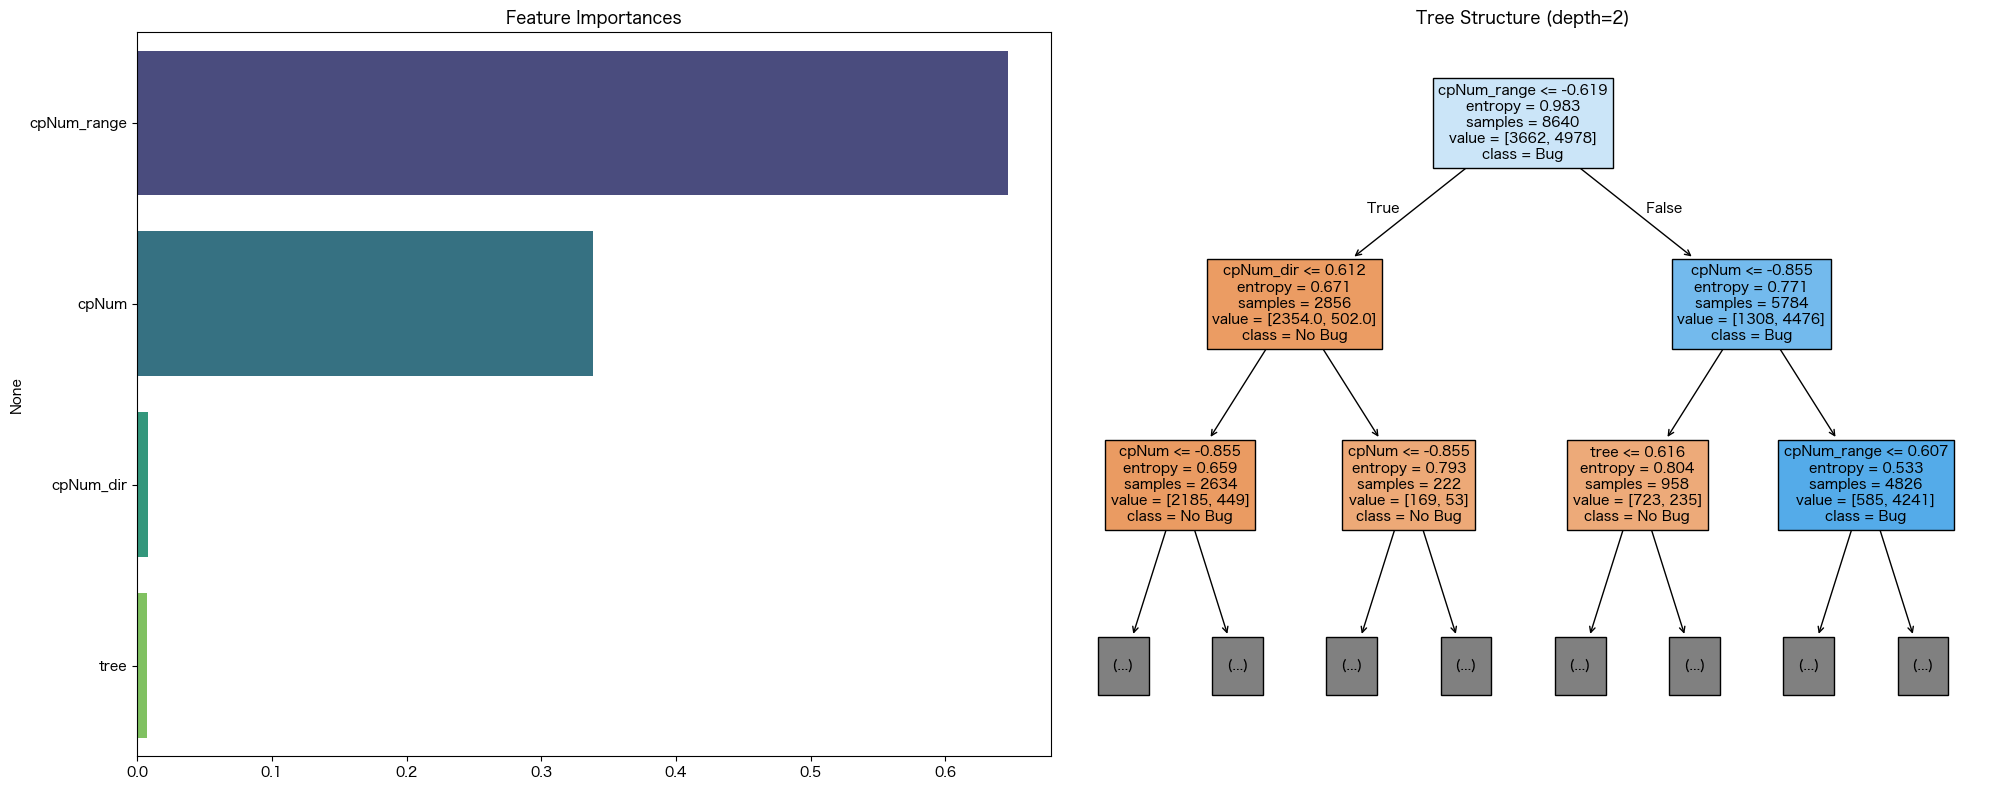

In [5]:
best_model_dt = grid_search_dt.best_estimator_
y0_pred = best_model_dt.predict(X0_test)

print("【テストデータでの評価】")
print(f"Accuracy:  {accuracy_score(y0_test, y0_pred):.4f}")
print(f"Precision: {precision_score(y0_test, y0_pred):.4f}")
print(f"Recall:    {recall_score(y0_test, y0_pred):.4f}")
print(f"F1-Score:  {f1_score(y0_test, y0_pred):.4f}")

print("\n【混同行列】")
print(confusion_matrix(y0_test, y0_pred))

best_dt_inner = best_model_dt.named_steps['dt']
importances = pd.Series(best_dt_inner.feature_importances_, index=X0.columns).sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.barplot(x=importances.values, y=importances.index, palette='viridis', ax=ax1)
ax1.set_title('Feature Importances')

plot_tree(best_dt_inner, feature_names=X0.columns, class_names=['No Bug', 'Bug'], filled=True, max_depth=2, ax=ax2, fontsize=10)
ax2.set_title('Tree Structure (depth=2)')

plt.tight_layout()
plt.show()

## 探索プロセスの可視化

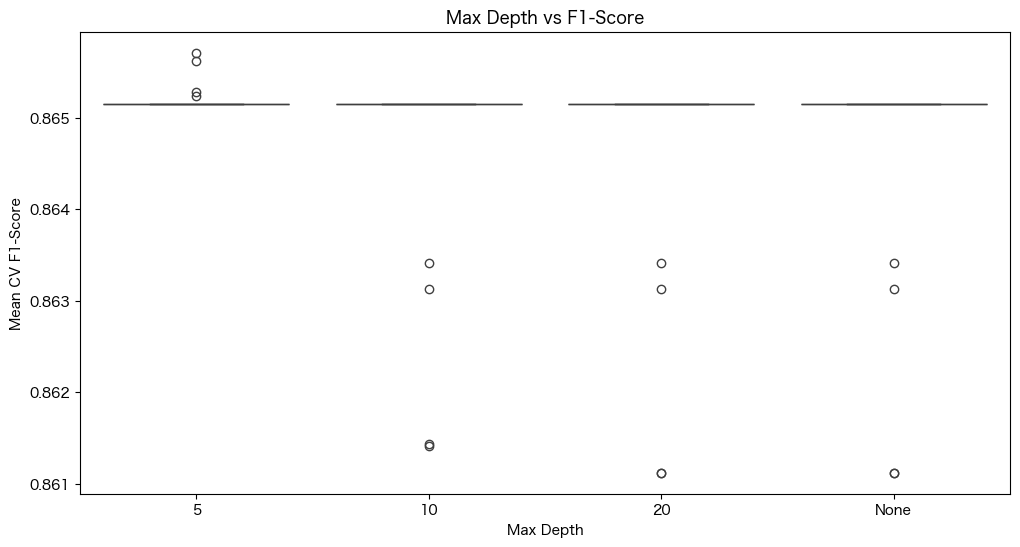

In [6]:
results_df = pd.DataFrame(grid_search_dt.cv_results_)

# 1. 文字列に変換（Noneは 'None' になる）
results_df['param_dt__max_depth'] = results_df['param_dt__max_depth'].astype(str)

# 2. 明示的な並び順を作成してソートエラーを封じ込める
depth_levels = results_df['param_dt__max_depth'].unique()
numeric_levels = sorted([d for d in depth_levels if d != 'None'], key=lambda x: int(x))
order = numeric_levels + (['None'] if 'None' in depth_levels else [])

plt.figure(figsize=(12, 6))
# 3. order 引数で並び順を固定し、ライブラリによる自動比較を回避する
sns.boxplot(x='param_dt__max_depth', y='mean_test_score', data=results_df, order=order)
plt.title('Max Depth vs F1-Score')
plt.xlabel('Max Depth')
plt.ylabel('Mean CV F1-Score')
plt.show()